In [1]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras.models import Model

plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 16

In [2]:
dataset_path = kagglehub.dataset_download("quadeer15sh/augmented-forest-segmentation")

print("Path to dataset files:", dataset_path)

100%|██████████| 172M/172M [00:09<00:00, 18.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/quadeer15sh/augmented-forest-segmentation/versions/2


In [3]:
# Define the paths to the dataset
dataset_path = "/root/.cache/kagglehub/datasets/quadeer15sh/augmented-forest-segmentation/versions/2"
dataset_content_path = os.path.join(dataset_path, "Forest Segmented")
nested_content_path = os.path.join(dataset_content_path, "Forest Segmented")
images_folder = os.path.join(nested_content_path, "images")
masks_folder = os.path.join(nested_content_path, "masks")

In [4]:
test_root = os.path.join(nested_content_path, 'test')
test_img_dir = os.path.join(test_root, 'images')
test_mask_dir = os.path.join(test_root, 'masks')
os.makedirs(test_img_dir, exist_ok=True)
os.makedirs(test_mask_dir, exist_ok=True)
print("Dataset contents:", os.listdir(test_root))

Dataset contents: ['images', 'masks']


In [5]:
image_files = sorted(os.listdir(images_folder))
mask_files = sorted(os.listdir(masks_folder))

In [6]:
train_imgs, test_imgs = train_test_split(image_files, test_size=0.15, random_state=42)

for fname in test_imgs:
    # Extract the base filename (without extension)
    base_fname = fname.split('.')[0]  # Splitting at '.' and taking the first part

    # Construct the mask filename based on the image filename
    mask_fname = base_fname.replace('_sat_', '_mask_') + '.jpg'

    shutil.move(os.path.join(images_folder, fname), os.path.join(test_img_dir, fname))
    shutil.move(os.path.join(masks_folder, mask_fname), os.path.join(test_mask_dir, mask_fname))

In [7]:
print("Dataset contents:", os.listdir(nested_content_path))
print("Images Folder:", images_folder)
print("Masks Folder:", masks_folder)

Dataset contents: ['test', 'images', 'meta_data.csv', 'masks']
Images Folder: /root/.cache/kagglehub/datasets/quadeer15sh/augmented-forest-segmentation/versions/2/Forest Segmented/Forest Segmented/images
Masks Folder: /root/.cache/kagglehub/datasets/quadeer15sh/augmented-forest-segmentation/versions/2/Forest Segmented/Forest Segmented/masks


In [8]:
# Load image and mask metadata from CSV
csv_path = os.path.join(nested_content_path, "meta_data.csv")
data = pd.read_csv(csv_path)
data.head()

image                mask
0   10452_sat_08.jpg   10452_mask_08.jpg
1   10452_sat_18.jpg   10452_mask_18.jpg
2  111335_sat_00.jpg  111335_mask_00.jpg
3  111335_sat_01.jpg  111335_mask_01.jpg
4  111335_sat_02.jpg  111335_mask_02.jpg

In [9]:
""" Image preprocessing and data generation """

# Sets the image dimensions
img_dim = 256

batch_size = 32

# Data augmentation and normalization (set pixel values to range 0 to 1)
image_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.15)
mask_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.15)

# Function to combine image and mask generators
def image_mask_generator(image_gen, mask_gen):
    for img, mask in zip(image_gen, mask_gen):
        yield img, mask  # Returns (image, mask) pair

train_image_generator = image_datagen.flow_from_directory(
        nested_content_path,
        target_size=(img_dim, img_dim), # 256 * 256 dimension
        class_mode=None,
        classes = ['images'],
        batch_size = batch_size,
        seed=42, # random state for reproducibility
        subset='training')

train_mask_generator = mask_datagen.flow_from_directory(
        nested_content_path,
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['masks'],
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed=42,
        subset='training')

train_generator = image_mask_generator(train_image_generator, train_mask_generator)

val_image_generator = image_datagen.flow_from_directory(
        nested_content_path,
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['images'],
        batch_size = batch_size,
        seed=42,
        subset='validation')

val_mask_generator = mask_datagen.flow_from_directory(
        nested_content_path,
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['masks'],
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed=42,
        subset='validation')

val_generator = image_mask_generator(val_image_generator, val_mask_generator)

# Test generators
test_image_datagen = ImageDataGenerator(rescale=1./255)
test_mask_datagen = ImageDataGenerator(rescale=1./255)

test_image_generator = test_image_datagen.flow_from_directory(
        test_root,
        target_size=(img_dim, img_dim),
        class_mode=None,
        classes=['images'],
        batch_size=1,
        shuffle=False,
        seed=42)

test_mask_generator = test_mask_datagen.flow_from_directory(
        test_root,
        target_size=(img_dim, img_dim),
        class_mode=None,
        classes=['masks'],
        color_mode='grayscale',
        batch_size=1,
        shuffle=False,
        seed=42)

test_generator = image_mask_generator(test_image_generator, test_mask_generator)

Found 3690 images belonging to 1 classes.
Found 3690 images belonging to 1 classes.
Found 651 images belonging to 1 classes.
Found 651 images belonging to 1 classes.
Found 767 images belonging to 1 classes.
Found 767 images belonging to 1 classes.


In [10]:
training_samples_size = train_image_generator.samples
val_samples_size = val_image_generator.samples
test_samples_size = test_image_generator.samples
print("Number of training samples:", training_samples_size)
print("Number of validation samples:", val_samples_size)
print("Number of test samples:", test_samples_size)

Number of training samples: 3690
Number of validation samples: 651
Number of test samples: 767


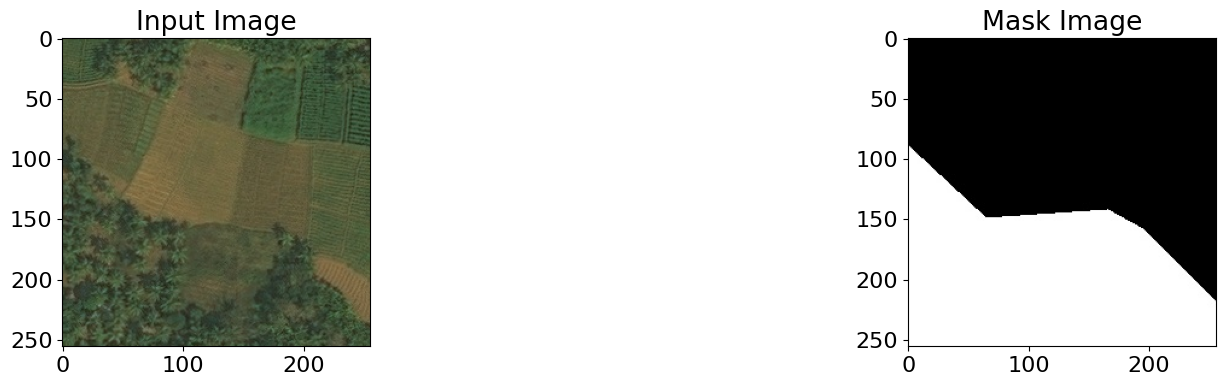

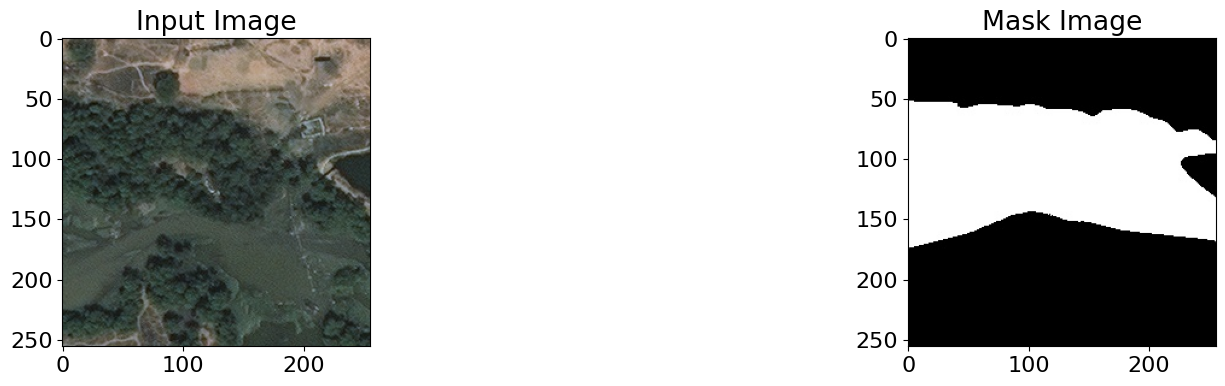

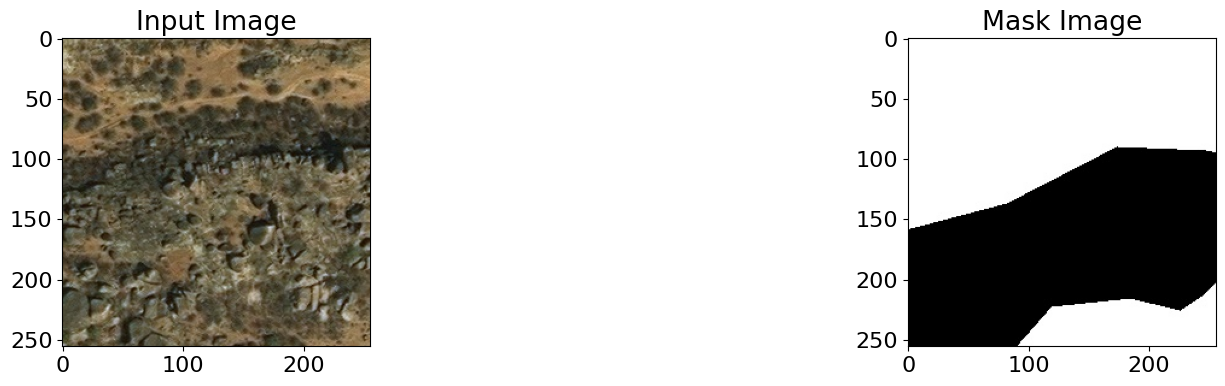

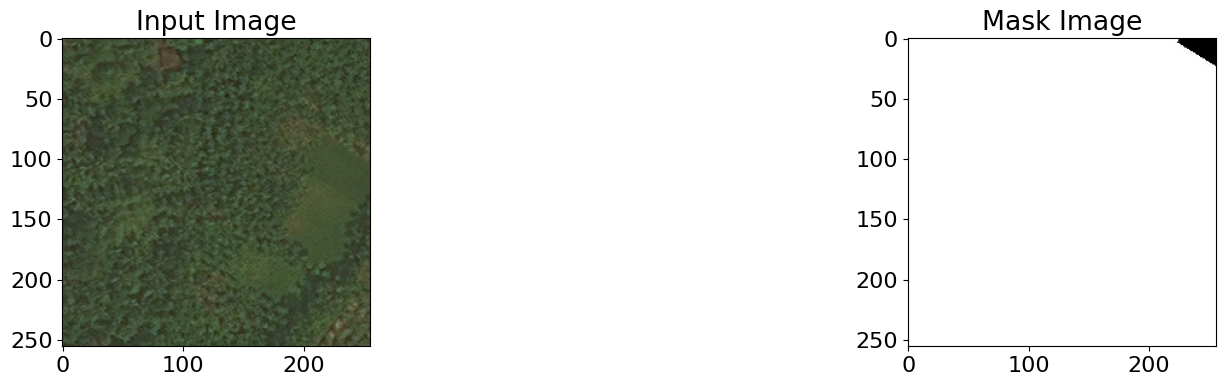

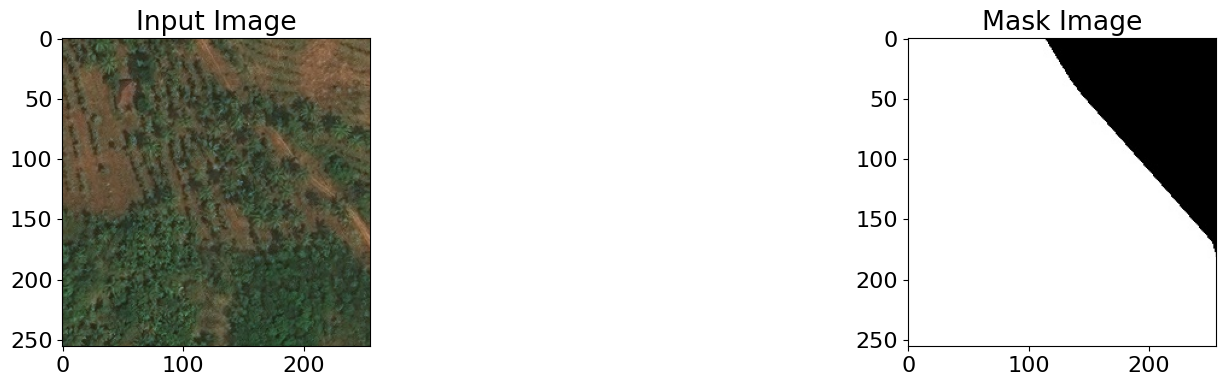

In [11]:
"""Visulaizing the images and masks"""
""" The white regions are the forested areas and the black regions are the non-forest areas"""
n = 0
for i,m in train_generator:
    img,mask = i,m

    if n < 5:
        fig, axs = plt.subplots(1 , 2, figsize=(20,4))
        axs[0].imshow(img[0])
        axs[0].set_title('Input Image')
        axs[1].imshow(mask[0],cmap='gray')
        axs[1].set_title('Mask Image')
        plt.show()
        n+=1
    else:
        break

In [12]:
"""U-Net Model Architecture"""

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

# Skip connections to allow the input to be passed along unchanged
# so we can avoid the degradation caused by the deep ResNet50 architecture
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    """ Building the U-Net model with ResNet50 as the encoder. """
    inputs = Input(input_shape)


    """Transfer learning using pre-trained ResNet50 and
    ImageNet weights for feature extraction"""

    resnet = ResNet50(weights="imagenet", include_top=False, input_tensor=inputs)

    # Extracting encoder feature maps
    s1 = resnet.get_layer("conv1_relu").output   # 256 filters
    s2 = resnet.get_layer("conv2_block3_out").output  # 256 filters
    s3 = resnet.get_layer("conv3_block4_out").output  # 512 filters
    s4 = resnet.get_layer("conv4_block6_out").output  # 1024 filters

    # Bottleneck layer
    b1 = resnet.get_layer("conv5_block3_out").output  # 2048 filters

    # Decoder path for upsampling
    d1 = decoder_block(b1, s4, 1024)
    d2 = decoder_block(d1, s3, 512)
    d3 = decoder_block(d2, s2, 256)
    d4 = decoder_block(d3, s1, 64)
    d5 = decoder_block(d4, inputs, 32)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d5)

    model = Model(inputs, outputs, name="ResNet50-U-Net")
    return model

In [13]:
""" Defining the IoU and precision metrics """

# To identify distinct objects in the masks
from skimage.measure import label

from tensorflow import keras
from tensorflow.keras import backend

# Calculates the IoU coefficient
def iou_coef(y_true, y_pred, smooth=1):
    intersection = keras.backend.sum(keras.backend.abs(y_true * y_pred), axis=[1,2,3])
    union = keras.backend.sum(y_true,[1,2,3])+keras.backend.sum(y_pred,[1,2,3])-intersection
    iou = keras.backend.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def iou_coef_loss(y_true, y_pred):
    return -iou_coef(y_true, y_pred)

# Calculates mean average precision (MAP) over a range of IoU thresholds
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)

    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas needed for finding the union between all objects
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the IoU
    iou = intersection / union

    # Precision matrix
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1
        false_positives = np.sum(matches, axis=0) == 0
        false_negatives = np.sum(matches, axis=1) == 0
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loops over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)

    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

#Calculates IoU for each sample in a batch and returns the average
def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.compat.v1.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

In [14]:
input_shape = (img_dim, img_dim, 3)
model = build_unet(input_shape)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss = ['binary_crossentropy'], metrics=[iou_coef,'accuracy'])
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "ResNet50-U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 71,981,089 (274.59 MB)

 Trainable params: 71,920,417 (274.35 MB)

 Non-trainable params: 60,672 (237.00 KB)

In [15]:
# Early stopping for gradient descent which stops training after
# it notices no improvement in training
earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 10, # training stops after plateaued metrics
                          verbose = 1,
                          restore_best_weights = True)



In [16]:
#training the model
callbacks = [earlystop]
batch_size = 32
steps_per_epoch = training_samples_size//batch_size
validation_steps = val_samples_size//batch_size
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    epochs=30, callbacks=callbacks)

Epoch 1/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - accuracy: 0.7379 - iou_coef: 0.4876 - loss: 0.5209 - val_accuracy: 0.3686 - val_iou_coef: 0.0044 - val_loss: 9.4615
Epoch 2/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.8460 - iou_coef: 0.5989 - loss: 0.3451 - val_accuracy: 0.3577 - val_iou_coef: 0.0022 - val_loss: 10.4114
Epoch 3/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step - accuracy: 0.8937 - iou_coef: 0.6464 - loss: 0.2561 - val_accuracy: 0.3522 - val_iou_coef: 0.0052 - val_loss: 4.9497
Epoch 4/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.9161 - iou_coef: 0.6861 - loss: 0.2037 - val_accuracy: 0.3643 - val_iou_coef: 0.0026 - val_loss: 7.3366
Epoch 5/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.9311 - iou_coef: 0.7172 - loss: 0.1694 - val_accuracy: 0.3549 - val_iou_coef: 0.0062 - val_loss: 4.0227
Epoch 6/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.9449 - iou_coef: 0.7585 - loss: 0.1376 - val_accuracy: 0.3584 - val_iou_coef:

In [17]:
import seaborn as sns
sns.set_style('dark')

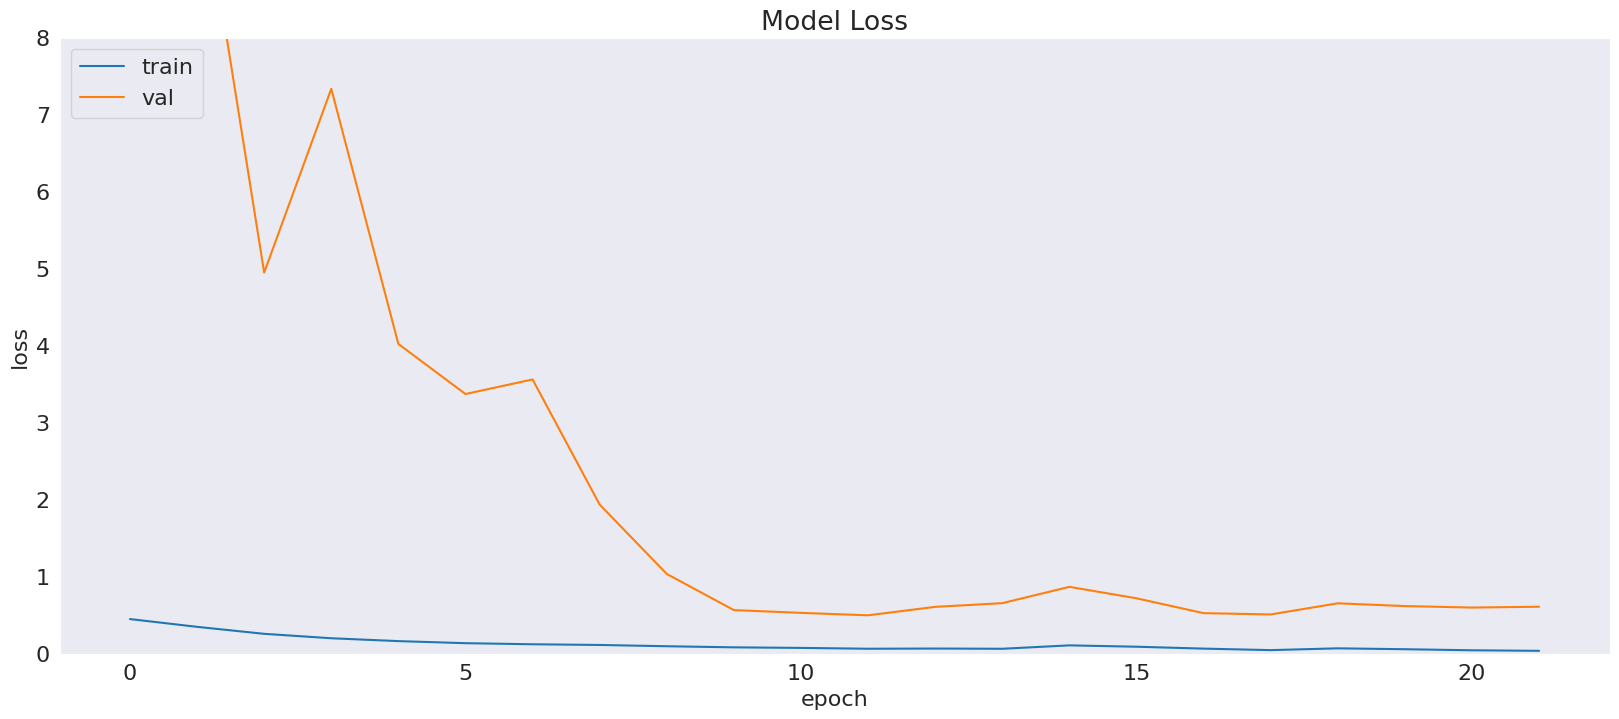

In [18]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,8])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
"""Evaluating the model on the entire test set"""
# # Predict on the entire test set
# iou_scores = []
# for i in range(test_image_generator.samples):  # Loop through all test samples
#     test_image_batch, test_mask_batch = test_generator.__next__() # Generates a batch of test data as a tuple
#     predicted_mask_batch = model.predict(test_image_batch)

#     # Apply thresholding
#     predicted_mask_batch[predicted_mask_batch >= 0.5] = 1
#     predicted_mask_batch[predicted_mask_batch < 0.5] = 0

#     # Calculate IoU for this batch and append to the list
#     iou_scores.append(iou_metric_batch(test_mask_batch, predicted_mask_batch))

# # Calculate and display the average test IoU
# average_test_iou = np.mean(iou_scores)
# print(f"Average Test IoU: {average_test_iou}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━

In [23]:
"""Evaluating the model on a batch test set"""
# Select a batch size for testing
test_batch_size = 32  # Adjust as needed

# Get a batch of test data
test_image_batch, test_mask_batch = next(test_generator)

# Make predictions on the batch
predicted_mask_batch = model.predict(test_image_batch)

# Apply thresholding
predicted_mask_batch[predicted_mask_batch >= 0.5] = 1
predicted_mask_batch[predicted_mask_batch < 0.5] = 0

# Calculate average IoU for the batch
average_iou = iou_metric_batch(test_mask_batch, predicted_mask_batch)

print(f"Average IoU for the batch: {average_iou}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Average IoU for the batch: 0.699999988079071


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


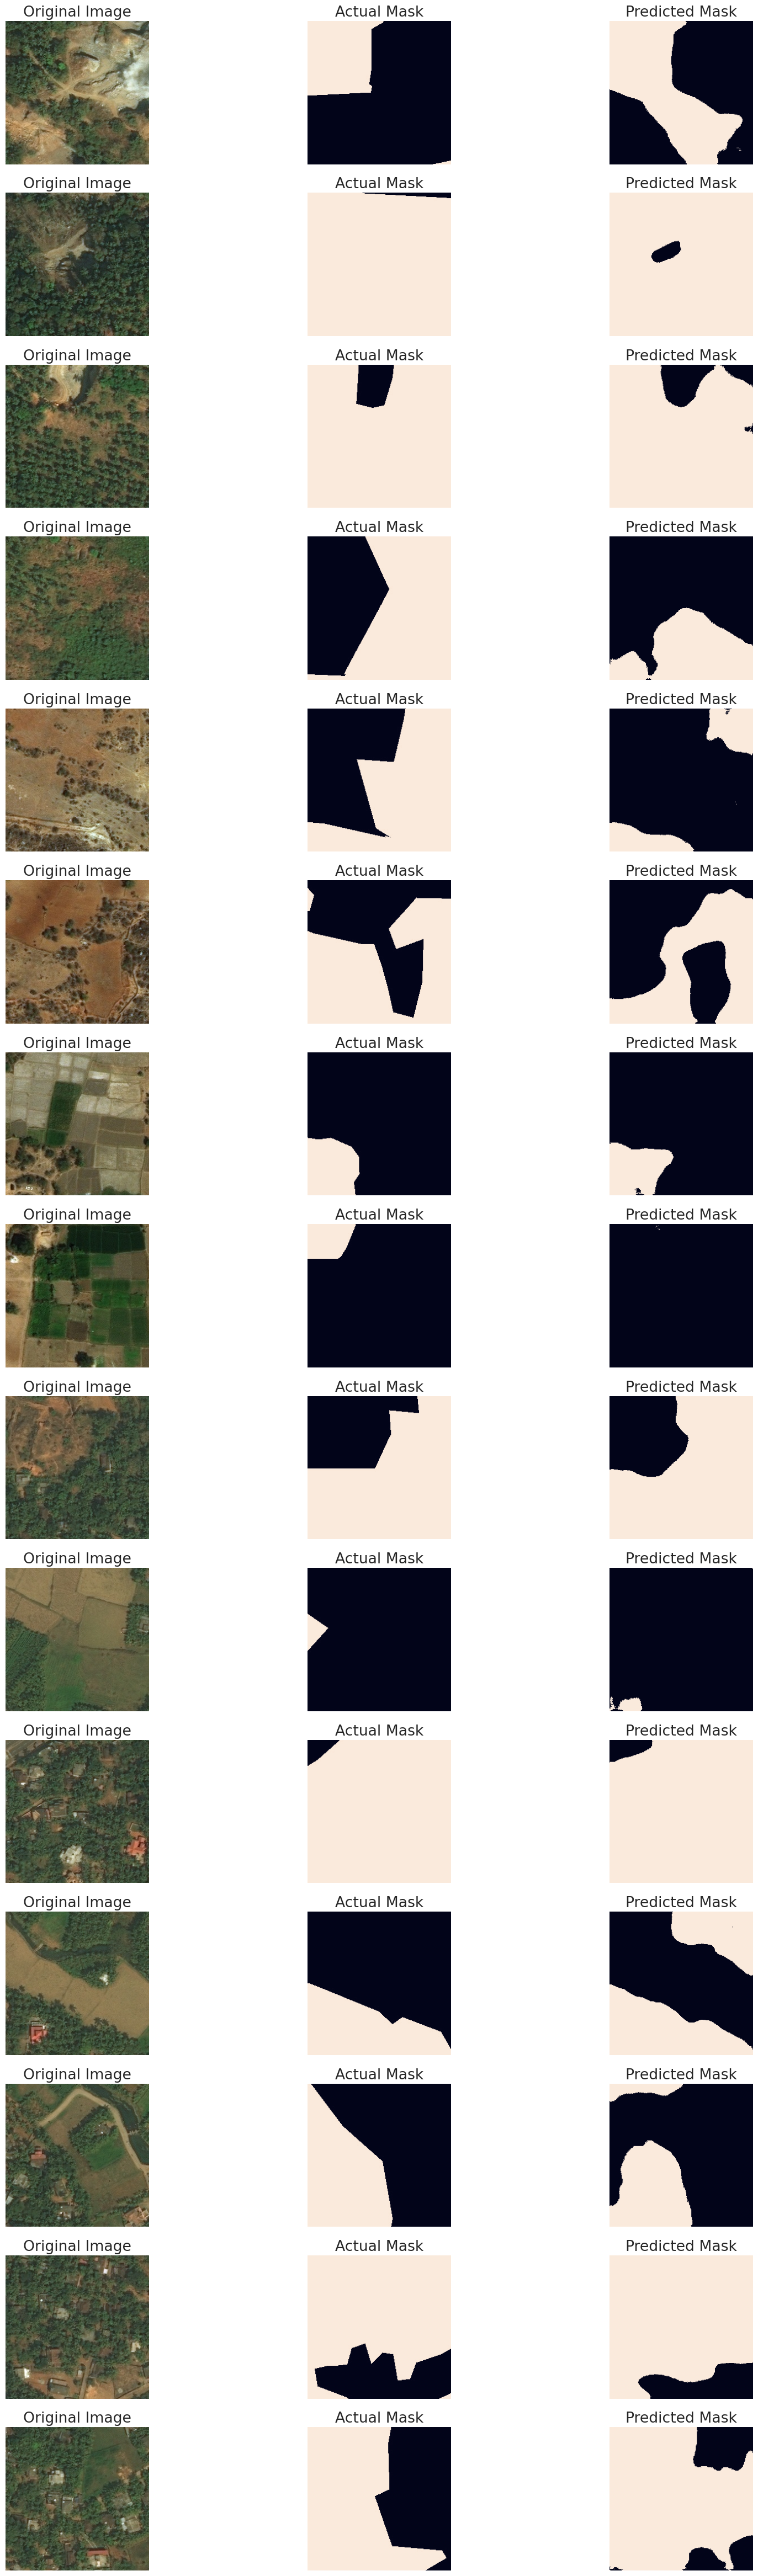

In [24]:
"""Visualizing the predicted masks against the Target masks"""

f, axarr = plt.subplots(15,3,figsize=(20, 60))

# Reset the test generator before the loop
test_generator = image_mask_generator(test_image_generator, test_mask_generator)

for i in range(0,15):
    # Get the next batch of test data
    test_image_batch, test_mask_batch = test_generator.__next__()
    predicted_mask_batch = model.predict(test_image_batch)

    # Apply thresholding
    predicted_mask_batch[predicted_mask_batch >= 0.5] = 1
    predicted_mask_batch[predicted_mask_batch < 0.5] = 0

    axarr[i,0].imshow(test_image_batch[0]) # Access the first (and only) element of the batch
    axarr[i,0].title.set_text('Original Image')
    axarr[i,0].axis('off')
    axarr[i,1].imshow(test_mask_batch[0]) # Access the first (and only) element of the batch
    axarr[i,1].title.set_text('Actual Mask')
    axarr[i,1].axis('off')
    axarr[i,2].imshow(predicted_mask_batch[0]) # Access the first (and only) element of the batch
    axarr[i,2].title.set_text('Predicted Mask')
    axarr[i,2].axis('off')